In [2]:

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import io
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
from matplotlib import rcParams
from numpy.fft import fft, ifft

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, LSTM
from keras import optimizers
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

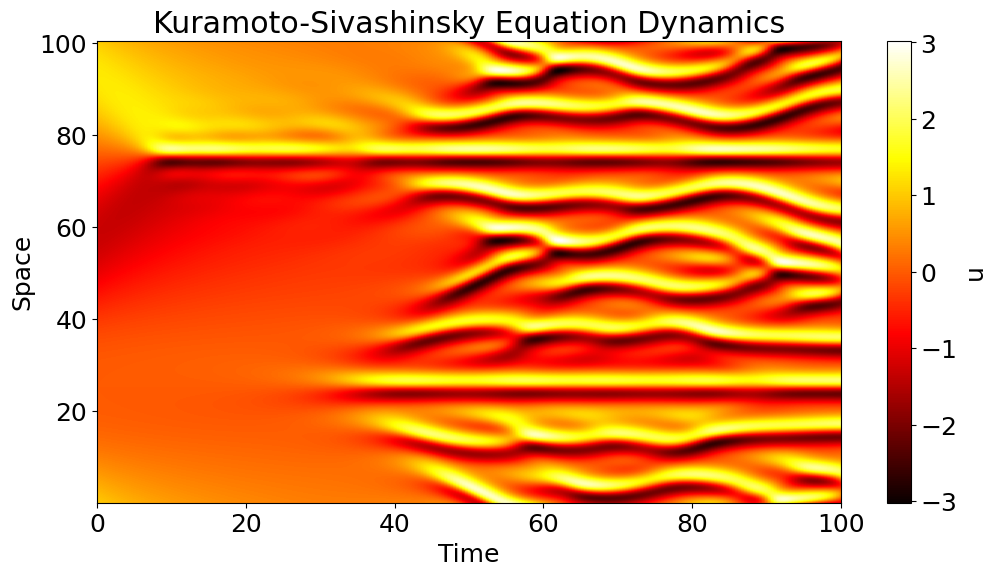

In [27]:
# Kuramoto-Sivashinsky equation (from Trefethen)
# u_t = -u*u_x - u_xx - u_xxxx, periodic BCs

# Kuramoto-Sivashinsky equation setup
N = 1024
x = 32 * np.pi * (np.arange(1, N + 1) / N).reshape(N, 1)
u = np.cos(x / 16) * (1 + np.sin(x / 16))
u = u.reshape(N)
v = fft(u)

# Parameters for the equation
h = 0.025
k = np.concatenate([np.arange(0, N/2), [0], np.arange(-N/2 + 1, 0)]) / 16
L = k**2 - k**4
E = np.exp(h*L)
E2 = np.exp(h*L/2)
M = 16
r = np.exp(1j * np.pi * (np.arange(1, M + 1) - 0.5) / M)
LR = h * np.outer(L, np.ones(M)) + np.outer(np.ones(N), r)
Q = h * np.real(np.mean((np.exp(LR/2) - 1) / LR, axis=1))
f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3*LR + LR**2)) / LR**3, axis=1))
f2 = h * np.real(np.mean((2 + LR + np.exp(LR) * (-2 + LR)) / LR**3, axis=1))
f3 = h * np.real(np.mean((-4 - 3*LR - LR**2 + np.exp(LR) * (4 - LR)) / LR**3, axis=1))

# Time-stepping loop
tmax = 100
nmax = round(tmax/h)
nplt = int((tmax/250)/h)
g = -0.5j * k
uu = u[:, np.newaxis]
tt = 0

for n in range(1, nmax + 1):
    t = n * h
    Nv = g * fft(np.real(ifft(v))**2)
    a = E2 * v + Q * Nv
    Na = g * fft(np.real(ifft(a))**2)
    b = E2 * v + Q * Na
    Nb = g * fft(np.real(ifft(b))**2)
    c = E2 * a + Q * (2 * Nb - Nv)
    Nc = g * fft(np.real(ifft(c))**2)
    v = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3
    if n % nplt == 0:
        u = np.real(ifft(v))
        uu = np.hstack((uu, u.reshape(N, 1)))
        tt = np.append(tt, t)

plt.figure(figsize=(12, 6))
plt.imshow(uu, extent=[tt.min(), tt.max(), x.min(), x.max()], aspect='auto', cmap='hot')
plt.colorbar(label='u')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Kuramoto-Sivashinsky Equation Dynamics')
plt.show()

In [114]:
L = 20  # Choose a sequence length
feature_dim = 1024  # This is given by your data shape

nn_input = []
nn_output = []

from keras.layers import Flatten

model = Sequential([
    Dense(250, activation='sigmoid', input_shape=(L, feature_dim)),
    Dense(100, activation='relu'),
    Flatten(),  # Flatten the inputs to the final Dense layer
    Dense(feature_dim, activation='linear')  # Output layer matching the number of features
])

model.compile(loss='mse', optimizer='adam', metrics=['mse'])



for i in range(251 - L):
    sequence = uu_scaled[:, i:i+L].T  # Transpose to shape [L, feature_dim]
    next_step = uu_scaled[:, i+L]

    nn_input.append(sequence)  # Shape: [L, feature_dim]
    nn_output.append(next_step)


# Convert to numpy arrays (if not already done)
nn_input = np.array(nn_input)  # Shape should be [num_sequences, L, feature_dim]
nn_output = np.array(nn_output)  # Shape should be [num_sequences, feature_dim]

# Check the shape of nn_input and nn_output
print("nn_input shape:", nn_input.shape)
print("nn_output shape:", nn_output.shape)

# Split the data
nn_input_train, nn_input_test, nn_output_train, nn_output_test = train_test_split(
    nn_input, nn_output, test_size=0.2, random_state=42
)


    # Fitting the model
history = model.fit(nn_input_train, nn_output_train, epochs=100)

nn_input shape: (231, 20, 1024)
nn_output shape: (231, 1024)
Epoch 1/100
6/6 [==============================] - 1s 28ms/step - loss: 0.1808 - mse: 0.1808
Epoch 2/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0444 - mse: 0.0444
Epoch 3/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0359 - mse: 0.0359
Epoch 4/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0288 - mse: 0.0288
Epoch 5/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0246 - mse: 0.0246
Epoch 6/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0211 - mse: 0.0211
Epoch 7/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0190 - mse: 0.0190
Epoch 8/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0169 - mse: 0.0169
Epoch 9/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0145 - mse: 0.0145
Epoch 10/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0125 - mse: 0.0125
Epoch 11

In [137]:
# Initialize current_sequence with the first sequence from nn_input_test
current_sequence = nn_input_test[0]  # Assuming shape is [L, feature_dim]

predicted_states = []

for _ in range(470):
    # Reshape current_sequence to match the model's expected input shape
    sequence_to_predict = current_sequence[np.newaxis, ...]  # Shape: [1, L, feature_dim]
    next_state = model.predict(sequence_to_predict)

    # Append the predicted state
    predicted_states.append(next_state)

    # Update the sequence: remove the oldest state and append the new state
    # next_state needs to be reshaped or sliced to match the shape of the states in current_sequence
    next_state_reshaped = next_state[-1, :]  # Reshape or slice next_state as needed
    current_sequence = np.vstack([current_sequence[1:], next_state_reshaped])

predicted_states = np.array(predicted_states).reshape(-1, feature_dim)


1/1 [==============================] - 0s 49ms/step


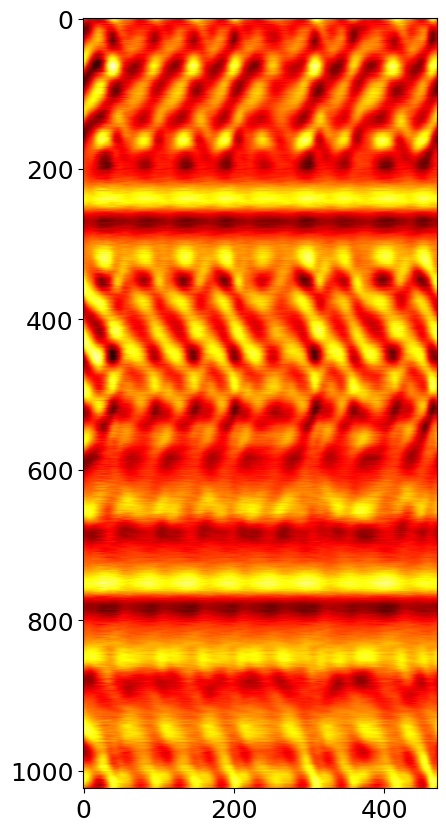

In [138]:
plt.figure(figsize=(15, 10))
plt.imshow(predicted_states.T, cmap = 'hot')

In [139]:
from sklearn.metrics import mean_squared_error

# Let's assume you have an array of predictions for the test set, called predicted_states_test
# And you already have nn_output_test from your earlier splitting of data

# Make sure the shapes of the predicted and true states match
# Here, we reshape predicted_states_test just in case it does not match the shape of nn_output_test
predicted_states_test = predicted_states.reshape(nn_output_test.shape)

# Calculate the mean squared error
mse = mean_squared_error(nn_output_test, predicted_states)

print(f"The Mean Squared Error on the test set is: {mse}")


ValueError: cannot reshape array of size 481280 into shape (47,1024)

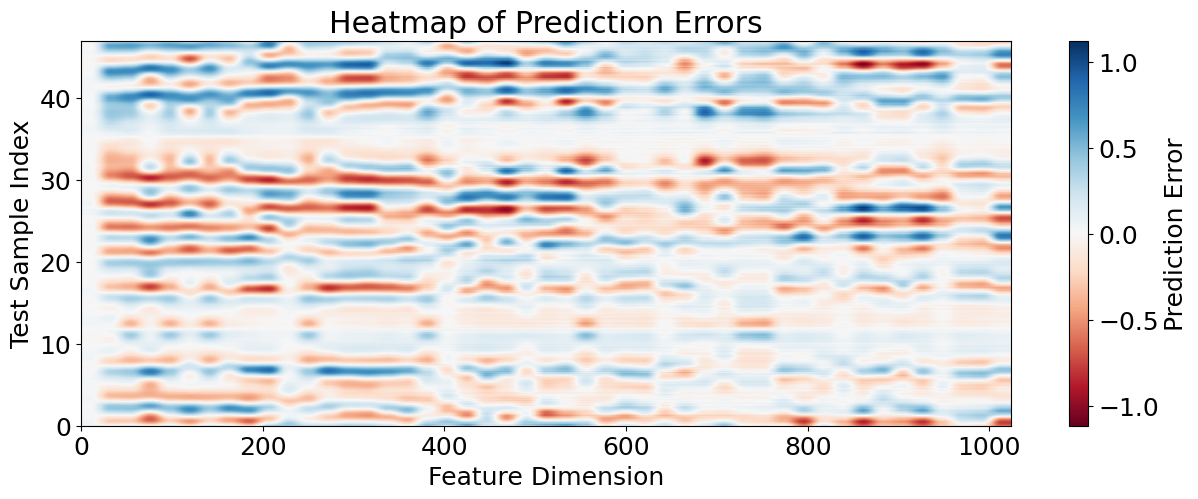

In [132]:
import matplotlib.pyplot as plt

# Calculate the difference (error) between the true and predicted states
errors = nn_output_test - predicted_states_test

# Plotting the error heatmap
plt.figure(figsize=(15, 5))
plt.imshow(errors.T, aspect='auto', cmap='RdBu', extent=[0, errors.shape[1], 0, errors.shape[0]])
plt.colorbar(label='Prediction Error')
plt.xlabel('Feature Dimension')
plt.ylabel('Test Sample Index')
plt.title('Heatmap of Prediction Errors')
plt.show()


In [133]:
# Initialize current_sequence with the first sequence from nn_input_test
current_sequence = nn_input_test[-1]  # Assuming shape is [L, feature_dim]

predicted_states = []

for _ in range(1000):
    # Reshape current_sequence to match the model's expected input shape
    sequence_to_predict = current_sequence[np.newaxis, ...]  # Shape: [1, L, feature_dim]
    next_state = model.predict(sequence_to_predict)

    # Append the predicted state
    predicted_states.append(next_state)

    # Update the sequence: remove the oldest state and append the new state
    # next_state needs to be reshaped or sliced to match the shape of the states in current_sequence
    next_state_reshaped = next_state[-1, :]  # Reshape or slice next_state as needed
    current_sequence = np.vstack([current_sequence[1:], next_state_reshaped])

predicted_states = np.array(predicted_states).reshape(-1, feature_dim)


1/1 [==============================] - 0s 57ms/step


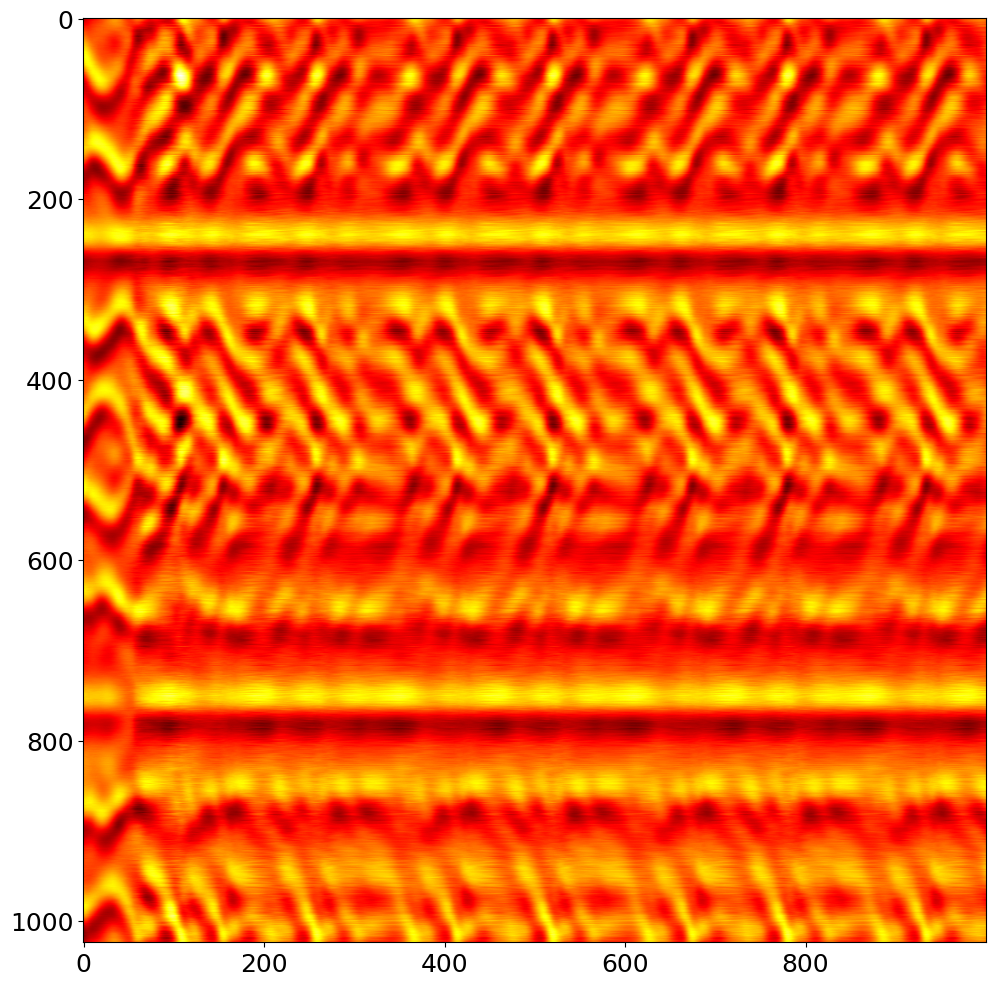

In [134]:
plt.imshow(predicted_states.T, cmap='hot')

In [93]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
L = 10  # Choose a sequence length
feature_dim = 1024  # This is given by your data shape

nn_input = []
nn_output = []

from keras.layers import Flatten

# Define the RNN model with LSTM layers
model = Sequential([
    LSTM(50, input_shape=(L, feature_dim), return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(100, activation='relu'),
    Dense(feature_dim, activation='linear')  # Output layer matching the number of features
])

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Summary of the model to see the stack of layers and parameters
model.summary()



for i in range(251 - L):
    sequence = uu_scaled[:, i:i+L].T  # Transpose to shape [L, feature_dim]
    next_step = uu_scaled[:, i+L]

    nn_input.append(sequence)  # Shape: [L, feature_dim]
    nn_output.append(next_step)


# Convert to numpy arrays (if not already done)
nn_input = np.array(nn_input)  # Shape should be [num_sequences, L, feature_dim]
nn_output = np.array(nn_output)  # Shape should be [num_sequences, feature_dim]

# Check the shape of nn_input and nn_output
print("nn_input shape:", nn_input.shape)
print("nn_output shape:", nn_output.shape)

# Split the data
nn_input_train, nn_input_test, nn_output_train, nn_output_test = train_test_split(
    nn_input, nn_output, test_size=0.2, random_state=42
)


    # Fitting the model
history = model.fit(nn_input_train, nn_output_train, epochs=100)


Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            215000    
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_169 (Dense)           (None, 100)               5100      
                                                                 
 dense_170 (Dense)           (None, 1024)              103424    
                                                                 
Total params: 343,724
Trainable params: 343,724
Non-trainable params: 0
_________________________________________________________________
nn_input shape: (241, 10, 1024)
nn_output shape: (241, 1024)
Epoch 1/100
6/6 [==============================] - 5s 40ms/step - loss: 0.2639 - mse: 0.2639
Epoch 2/100
6/6 [========

In [94]:
# Initialize current_sequence with the first sequence from nn_input_test
current_sequence = nn_input_test[0]  # Assuming shape is [L, feature_dim]

predicted_states = []

for _ in range(49):
    # Reshape current_sequence to match the model's expected input shape
    sequence_to_predict = current_sequence[np.newaxis, ...]  # Shape: [1, L, feature_dim]
    next_state = model.predict(sequence_to_predict)

    # Append the predicted state
    predicted_states.append(next_state)

    # Update the sequence: remove the oldest state and append the new state
    # next_state needs to be reshaped or sliced to match the shape of the states in current_sequence
    next_state_reshaped = next_state[-1, :]  # Reshape or slice next_state as needed
    current_sequence = np.vstack([current_sequence[1:], next_state_reshaped])

predicted_states = np.array(predicted_states).reshape(-1, feature_dim)


1/1 [==============================] - 0s 40ms/step


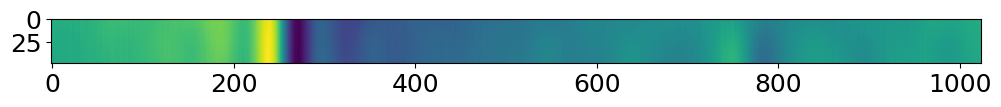

In [95]:
plt.imshow(predicted_states)

In [96]:
from sklearn.metrics import mean_squared_error

# Let's assume you have an array of predictions for the test set, called predicted_states_test
# And you already have nn_output_test from your earlier splitting of data

# Make sure the shapes of the predicted and true states match
# Here, we reshape predicted_states_test just in case it does not match the shape of nn_output_test
predicted_states_test = predicted_states.reshape(nn_output_test.shape)

# Calculate the mean squared error
mse = mean_squared_error(nn_output_test, predicted_states)

print(f"The Mean Squared Error on the test set is: {mse}")


The Mean Squared Error on the test set is: 0.04513403151343985


1/1 [==============================] - 0s 30ms/step


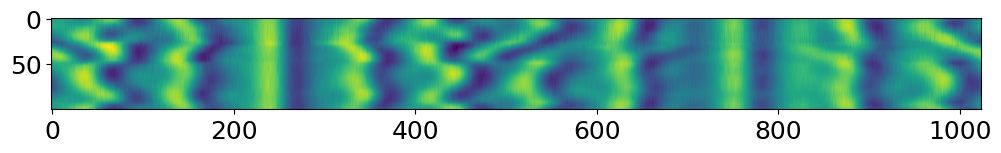

In [97]:
# Initialize current_sequence with the first sequence from nn_input_test
current_sequence = nn_input_test[-1]  # Assuming shape is [L, feature_dim]

predicted_states = []

for _ in range(100):
    # Reshape current_sequence to match the model's expected input shape
    sequence_to_predict = current_sequence[np.newaxis, ...]  # Shape: [1, L, feature_dim]
    next_state = model.predict(sequence_to_predict)

    # Append the predicted state
    predicted_states.append(next_state)

    # Update the sequence: remove the oldest state and append the new state
    # next_state needs to be reshaped or sliced to match the shape of the states in current_sequence
    next_state_reshaped = next_state[-1, :]  # Reshape or slice next_state as needed
    current_sequence = np.vstack([current_sequence[1:], next_state_reshaped])

predicted_states = np.array(predicted_states).reshape(-1, feature_dim)

plt.imshow(predicted_states)

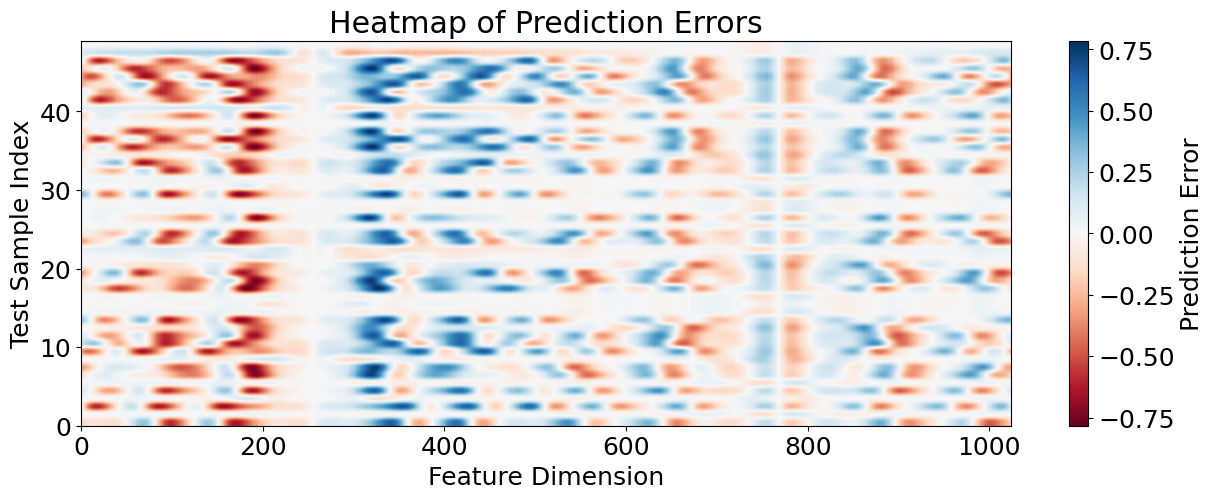

In [98]:
import matplotlib.pyplot as plt

# Calculate the difference (error) between the true and predicted states
errors = nn_output_test - predicted_states_test

# Plotting the error heatmap
plt.figure(figsize=(15, 5))
plt.imshow(errors, aspect='auto', cmap='RdBu', extent=[0, errors.shape[1], 0, errors.shape[0]])
plt.colorbar(label='Prediction Error')
plt.xlabel('Feature Dimension')
plt.ylabel('Test Sample Index')
plt.title('Heatmap of Prediction Errors')
plt.show()


In [17]:
import pandas as pd

chunksize = 50000  # Adjust based on memory constraints
chunks = []  # List to store data chunks
total_rows = chunksize * 2 + 103  # Total number of rows you want to read
rows_read = 0

for chunk in pd.read_csv("time_series_60min_singleindex.csv", chunksize=chunksize):
    chunks.append(chunk)
    rows_read += len(chunk)
    if rows_read >= total_rows:
        break  # Stop reading once enough rows are read

data = pd.concat(chunks, ignore_index=True)
print(data.shape)


C:\Users\mark.rainey\AppData\Local\Temp\ipykernel_13988\3493101121.py:8: DtypeWarning: Columns (262) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("time_series_60min_singleindex.csv", chunksize=chunksize):
C:\Users\mark.rainey\AppData\Local\Temp\ipykernel_13988\3493101121.py:8: DtypeWarning: Columns (262) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("time_series_60min_singleindex.csv", chunksize=chunksize):


(100103, 263)


In [23]:
import pandas as pd

# Load the dataset
df = pd.read_csv("time_series_60min_singleindex.csv")

# Filter columns related to Germany
german_columns = [col for col in df.columns if col.startswith('DE_')]
df_germany = df[german_columns]

# Fill missing values with 0
df_germany = df_germany.fillna(0)

# Now df_germany contains German data with missing values filled with 0


C:\Users\mark.rainey\AppData\Local\Temp\ipykernel_13988\2097752144.py:4: DtypeWarning: Columns (262) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("time_series_60min_singleindex.csv")


In [25]:
print(df_germany.head())

   DE_load_new  DE_load_old  DE_price_day_ahead  DE_solar_capacity  \
0          0.0          0.0                31.0             2001.0   
1          0.0          0.0                27.0             2001.0   
2          0.0          0.0                25.0             2001.0   
3          0.0          0.0                21.0             2001.0   
4          0.0          0.0                26.0             2001.0   

   DE_solar_generation  DE_solar_profile  DE_wind_capacity  \
0                  0.0               0.0               0.0   
1                  0.0               0.0               0.0   
2                  0.0               0.0               0.0   
3                  0.0               0.0               0.0   
4                  0.0               0.0               0.0   

   DE_wind_generation  DE_wind_profile  DE_wind_offshore_capacity  ...  \
0                 0.0              0.0                        0.0  ...   
1                 0.0              0.0                    